In [1]:
import os, re, torch
import pandas as pd
from torch_geometric.data import Data, InMemoryDataset

class PersonDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter) # pre_filter可根据需求筛选数据
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # 返回指定根目录下所有以 'SY' 开头并以 '.xlsx' 结尾的文件名，并按照数字部分排序
        files = [f for f in os.listdir(self.raw_dir) if f.startswith('SY') and f.endswith('.xlsx')]
        return sorted(files, key=lambda x: int(re.search(r'SY(\d+).xlsx', x).group(1))) if files else []

    @property
    def processed_file_names(self):
        return [f'person.pt']

    def download(self):
        pass
        
    def process(self):
        data_list = []
        raw_file_names = self.raw_file_names

        for idx, raw_filename in enumerate(raw_file_names):
            match = re.match(r'SY(\d+).xlsx', raw_filename)
            if match:
                label = int(match.group(1))  # 提取数字部分作为标签，从1开始
                raw_path = os.path.join(self.raw_dir, raw_filename) # 获取数据路径
             
                df = pd.read_excel(raw_path)
                # 假设第一行为表头，之后的每一行是一个节点
                features = df.values
                num_nodes = features.shape[0]
                node_ids = range(num_nodes)  # 构建节点ID

                # 构建 PyG 数据对象
                x = torch.tensor(features, dtype=torch.float)
                y = torch.tensor([label], dtype=torch.long)  # 图的标签，从1到60
                edge_index = self.construct_edges(node_ids)

                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)

        self.save(data_list, self.processed_paths[0])

    def construct_edges(self, node_ids):
        # 根据节点ID构建边，假设节点ID按顺序连接
        edge_index = []
        for i in range(len(node_ids) - 1):
            edge_index.append([node_ids[i], node_ids[i + 1]])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        return edge_index


dataset = PersonDataset(root=r'data/Person')

print(dataset)

PersonDataset(30)


In [2]:
from torch_geometric.loader import DataLoader

data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

for data in data_loader:
    print(data)
    print(data.y)

DataBatch(x=[299, 6], edge_index=[2, 298], y=[1], batch=[299], ptr=[2])
tensor([1])
DataBatch(x=[1400, 6], edge_index=[2, 1399], y=[1], batch=[1400], ptr=[2])
tensor([2])
DataBatch(x=[2400, 6], edge_index=[2, 2399], y=[1], batch=[2400], ptr=[2])
tensor([3])
DataBatch(x=[2000, 6], edge_index=[2, 1999], y=[1], batch=[2000], ptr=[2])
tensor([4])
DataBatch(x=[4100, 6], edge_index=[2, 4099], y=[1], batch=[4100], ptr=[2])
tensor([5])
DataBatch(x=[1840, 6], edge_index=[2, 1839], y=[1], batch=[1840], ptr=[2])
tensor([6])
DataBatch(x=[2500, 6], edge_index=[2, 2499], y=[1], batch=[2500], ptr=[2])
tensor([7])
DataBatch(x=[3100, 6], edge_index=[2, 3099], y=[1], batch=[3100], ptr=[2])
tensor([8])
DataBatch(x=[2000, 6], edge_index=[2, 1999], y=[1], batch=[2000], ptr=[2])
tensor([9])
DataBatch(x=[2000, 6], edge_index=[2, 1999], y=[1], batch=[2000], ptr=[2])
tensor([10])
DataBatch(x=[2155, 6], edge_index=[2, 2154], y=[1], batch=[2155], ptr=[2])
tensor([11])
DataBatch(x=[1500, 6], edge_index=[2, 1499],

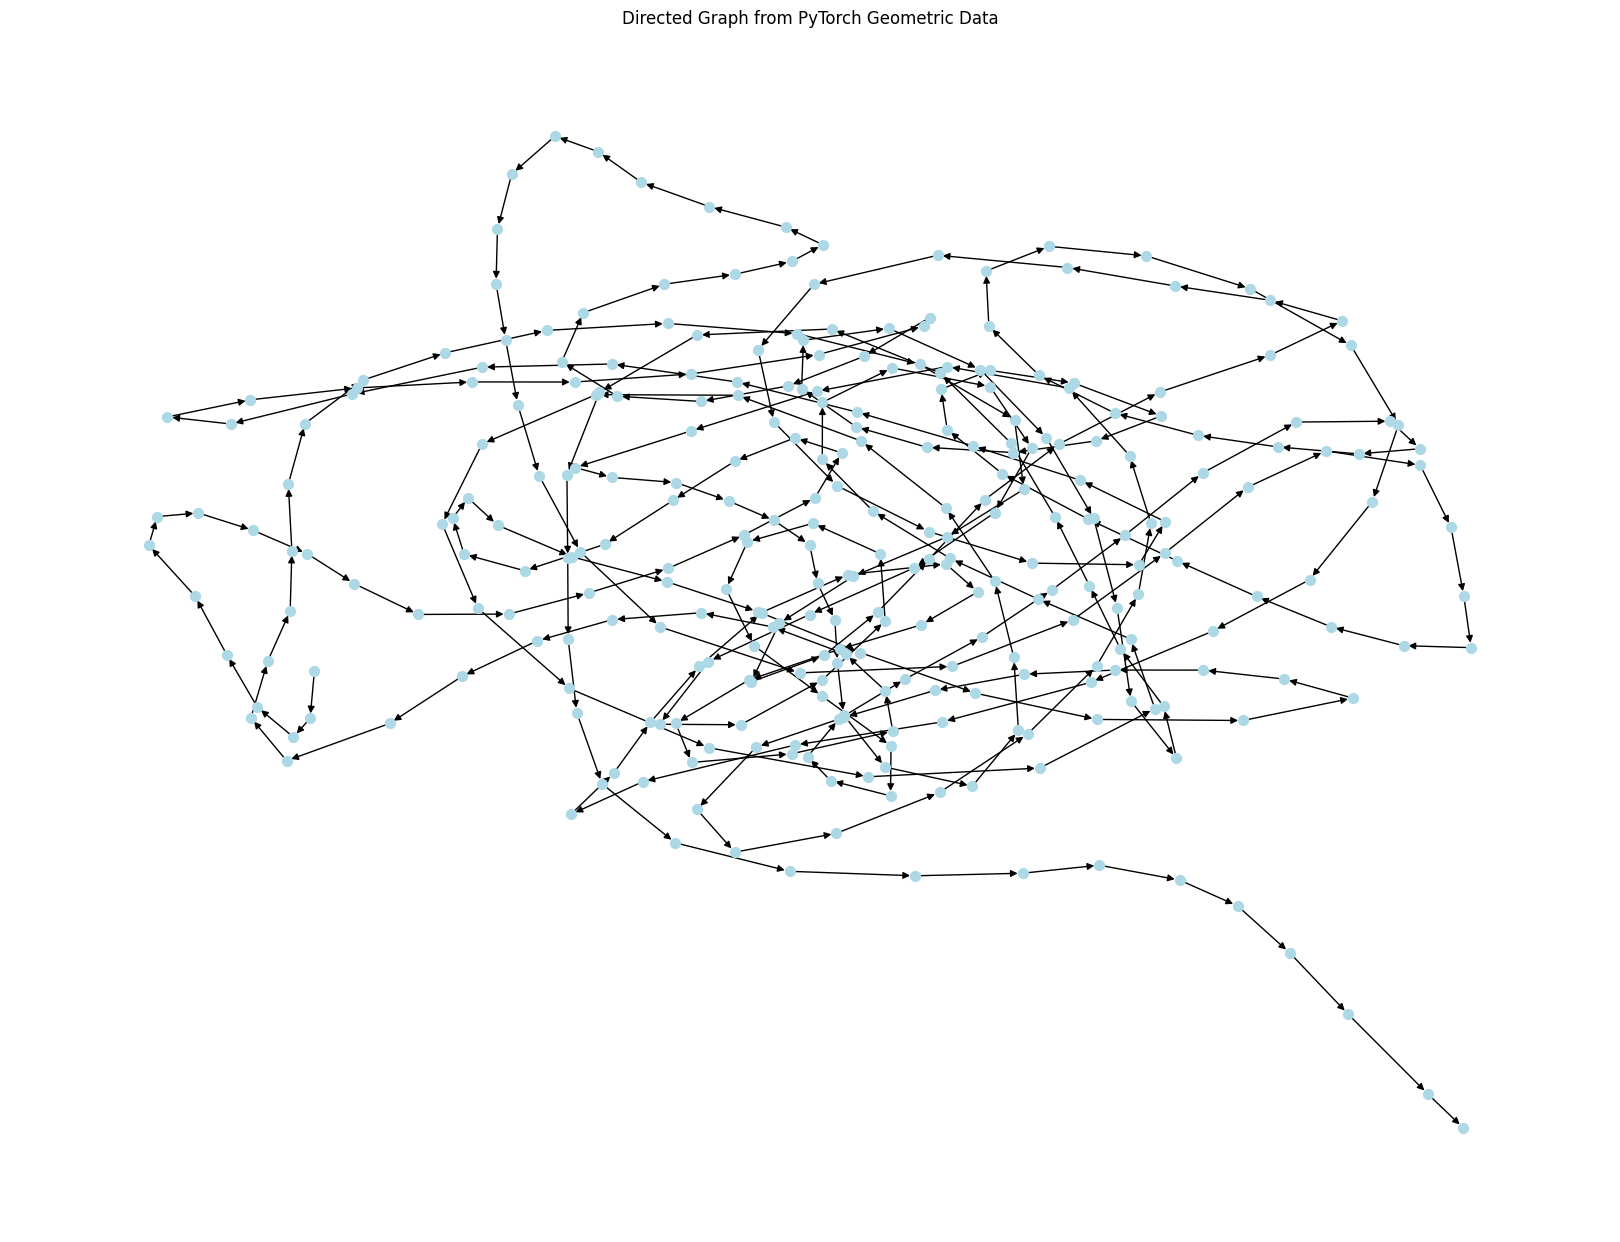

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

graph_data = dataset[0]

# 将 Data 对象转换为 NetworkX 有向图
G = nx.DiGraph()
G.add_nodes_from(range(graph_data.num_nodes))
for src, dst in graph_data.edge_index.t().tolist():  # 注意要转置边索引
    G.add_edge(src, dst)

# 使用 Spring layout 算法布局节点
pos = nx.spring_layout(G, seed=42)

# 绘制图形，增大节点大小和调整参数
plt.figure(figsize=(16, 12))  # 调整图形大小
nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=50, font_size=10, font_color='black', arrows=True)

# 显示图形
plt.title("Directed Graph from PyTorch Geometric Data")
plt.show()